Import

In [11]:
CUDA_LAUNCH_BLOCKING="1"

import os 
import warnings
warnings.simplefilter('ignore')

from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc

from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
import GPUtil
import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parameters

In [4]:
beta = 1                                        #Parameter of greedy optimizer, default 1
sample_size = 10                                #Parameter of greedy optimizer, default 10
eps = 0.1                                       #Parameter of greedy optimizer, default 0.1
k = 10                                          #Parameter of greedy optimizer, default 5

num_epochs = 10         
batch_size = 1
learning_rate = 1e-3

num_layers = 3
activation = 'relu'
intermediate_size = 100

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 10
N_INSTANCES = 10 
N_TRAIN = int(0.8 * N_INSTANCES)


Device

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



##### Instances definition

In [6]:
path = "instances_weibo/oversampled_FE_LP/"

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))

    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(path + f"{instance}.npz")['arr_0']
        if instance in train_id :
            X_train[c_train] = XY[:,:,:-1]
            Y_train[c_train] = XY[:,:,-1]
            c_train += 1
        else : 
            X_test[c_test] = XY[:,:,:-1]
            Y_test[c_test] = XY[:,:,-1]
            c_test += 1
    
    X_train[:,:,:,9] = Y_train * 2

    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    
    # test on random dense labels
    #Y_train = torch.bernoulli(torch.zeros(Y_train.size()),0.1)
    #Y_test = torch.bernoulli(torch.zeros(Y_test.size()),0.1)
    
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test



Definition of dataset

In [7]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
X_train, Y_train, X_test, Y_test = create_train_test(train_id)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 


### Decision focused

Evaluation function

In [8]:
def eval_grd(net, X, Y):
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([    set_func(   greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])

    return result

Training

In [14]:

print("epoch | loss | train_score | test_score ")

train_scores = []
test_scores  = []
loss_f = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)
net = net.to(device)
#net = net.half()
net.modules

epoch | loss | train_score | test_score 


<bound method Module.modules of Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Hardtanh(min_val=0, max_val=1.0)
)>

0 | -4895.17724609375 | 96.14851570129395 | 110.04167175292969
1 | -4906.2373046875 | 96.14851570129395 | 110.04167175292969
2 | -4848.70654296875 | 96.14851570129395 | 110.04167175292969
3 | -4900.21826171875 | 96.14851570129395 | 110.04167175292969
4 | -4890.37890625 | 96.14851570129395 | 110.04167175292969
5 | -4877.099609375 | 96.14851570129395 | 110.04167175292969
6 | -4912.44580078125 | 96.14851570129395 | 110.04167175292969
7 | -4906.23876953125 | 96.14851570129395 | 110.04167175292969
8 | -4848.6298828125 | 96.14851570129395 | 110.04167175292969
9 | -4870.3994140625 | 96.14851570129395 | 110.04167175292969


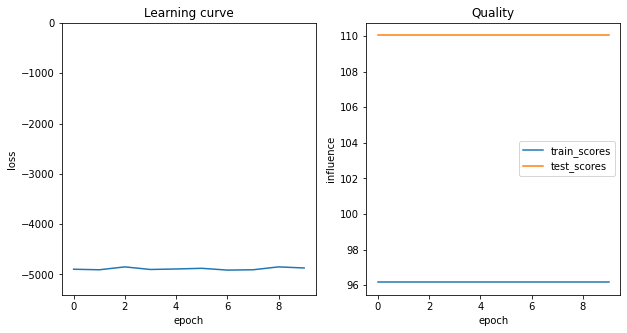

In [15]:

optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
marginal_vec_pred = partial(marginal_vec, w = w)

for epoch in range(num_epochs):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            
            true_set_func = partial(set_func, P = P, w = w)
            pred = net(X).view_as(P)                
            fn = GreedyOptimizer.apply
            loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta)
            del(X)
            del(P)
        
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_score = eval_grd(net, X_train, Y_train)
    test_score  = eval_grd(net, X_test, Y_test)
    loss_f.append(loss.item())
    
    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)
    

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(loss_f)
ax[0].set_title('Learning curve')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylim(1.1 * min(loss_f), 0)

ax[1].plot(train_scores, label="train_scores")
ax[1].plot(test_scores, label="test_scores")
ax[1].set_title('Quality')
ax[1].set_ylabel('influence')
ax[1].set_xlabel('epoch')
ax[1].legend()


Comparison with real network

In [117]:
def compare_grd(net,X,Y) : 
    pred = eval_grd(net, X,Y)
    
    X, Y = X.to(device), Y.to(device)
    th = np.mean([set_func(greedy(k, Y[i,:,:],w)[1],Y[i, :, :], w) for i in range(X.shape[0])])
    del(X)
    del(Y)
    print(f"The model predicts maximum influence {pred}")
    print(f"The real influence is {th}")
    
print("Decision_based on train dataset : ")
compare_grd(net, X_train, Y_train)

print("\n Decision_based on test dataset : ")
compare_grd(net, X_test, Y_test)

Decision_based on train dataset : 
The model predicts maximum influence 82.97887229919434
The real influence is 728.9129638671875

 Decision_based on test dataset : 
The model predicts maximum influence 98.0773811340332
The real influence is 736.0353088378906


### 2 Stage

epoch | loss | train_score | test_score 
0 | 0.08421877026557922 | 85.82113361358643 | 86.70833587646484
1 | 0.08423497527837753 | 85.82113361358643 | 86.70833587646484
2 | 0.08458986133337021 | 85.82113361358643 | 86.70833587646484
3 | 0.0837026834487915 | 85.82113361358643 | 86.70833587646484
4 | 0.08421877026557922 | 85.82113361358643 | 86.70833587646484
5 | 0.08323945105075836 | 85.82113361358643 | 86.70833587646484
6 | 0.08478827774524689 | 85.82113361358643 | 86.70833587646484
7 | 0.08421877026557922 | 85.82113361358643 | 86.70833587646484
8 | 0.08443130552768707 | 85.82113361358643 | 86.70833587646484
9 | 0.08410310000181198 | 85.82113361358643 | 86.70833587646484


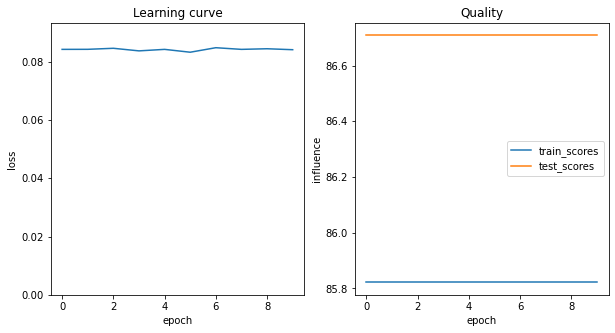

In [145]:

train_scores = []
test_scores  = []
loss_2 = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)
net = net.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.1)

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_score = eval_grd(net, X_train, Y_train)
    test_score  = eval_grd(net, X_test, Y_test)
    print(f"{epoch} | {loss} | {train_score} | {test_score}")    
    train_scores.append(train_score)
    test_scores.append(test_score)     
    loss_2.append(loss.item())

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(loss_2)
ax[0].set_title('Learning curve')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylim(0, 1.1 * max(loss_2))

ax[1].plot(train_scores, label="train_scores")
ax[1].plot(test_scores, label="test_scores")
ax[1].set_title('Quality')
ax[1].set_ylabel('influence')
ax[1].set_xlabel('epoch')
ax[1].legend()


2-stage on train dataset : 
The model predicts maximum influence 82.97887229919434
The real influence is 728.9129638671875

 2-stage on test dataset : 
The model predicts maximum influence 98.0773811340332
The real influence is 736.0353088378906


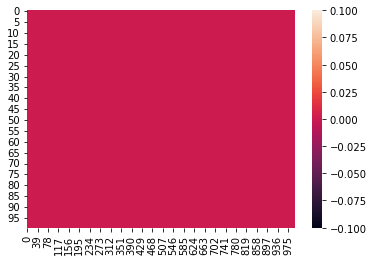

In [119]:
print("2-stage on train dataset : ")
compare_grd(net, X_train, Y_train)

print("\n 2-stage on test dataset : ")
compare_grd(net, X_test, Y_test)

### Random

Average score X_train : 608.9080645751953
Average score X_test : 612.529524230957


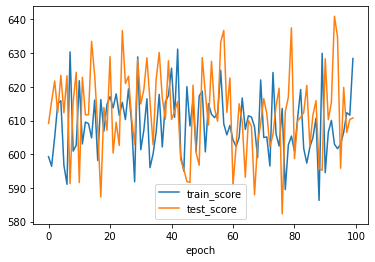

In [120]:

### main ###
train_scores = []
test_scores  = []
    

def eval_rnd(X, Y):
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

for _ in range(100) : 

    train_score = eval_rnd(X_train, Y_train)
    test_score  = eval_rnd(X_test, Y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

print(f"Average score X_train : {np.mean(train_scores)}")
print(f"Average score X_test : {np.mean(test_scores)}")

x = list(range(len(train_scores)))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()



### Plots


(-0.08, 0.0)

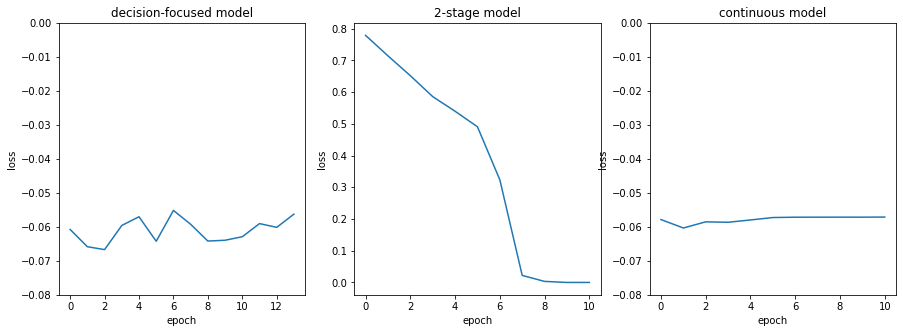

In [14]:
loss_decision = [-0.06076928973197937,-0.06584206968545914,-0.06670479476451874,-0.05958820879459381,-0.0570240244269371,-0.06424318253993988,-0.05516466125845909,-0.05924143642187118,-0.06418315321207047,-0.06394138187170029,-0.06290893256664276,-0.05904095247387886,-0.06015191227197647,-0.05625718086957931,]
loss_2_stage = [0.7789968252182007, 0.7144742012023926, 0.6519206762313843, 0.5859464406967163 ,0.5397264361381531 ,0.4908316731452942 ,0.32362160086631775, 0.022119728848338127, 0.00329726655036211, 9.616058378014714e-06,  1.4370152712217532e-06]
loss_CNT = [-0.057850807905197144,-0.06033829599618912,-0.058524295687675476,-0.05864942446351051,-0.057970765978097916,-0.05725716054439545,-0.05716206878423691,-0.0571533665060997,-0.057145409286022186,-0.05715050548315048,-0.05711754783987999,]

fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(loss_decision)
ax[0].set_title("decision-focused model")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_ylim(-0.08,0)

ax[1].plot(loss_2_stage)
ax[1].set_title("2-stage model")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")

ax[2].plot(loss_CNT)
ax[2].set_title("continuous model")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("loss")
ax[2].set_ylim(-0.08,0)

Text(0.5, 0, 'epoch')

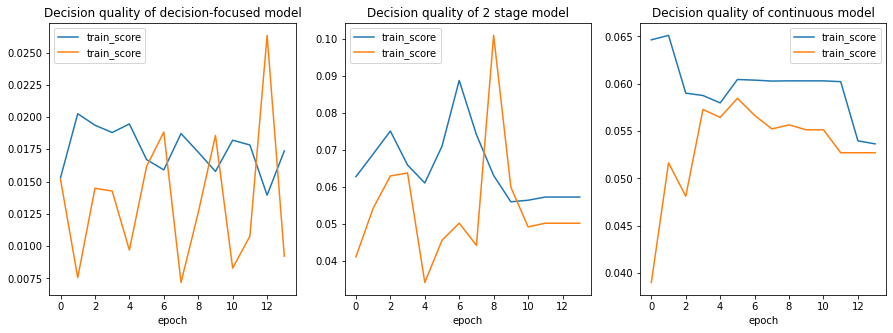

In [15]:
quality_decision_based_train=[0.015288348495960235,0.020257513225078582 ,0.01936897709965706  ,0.018799322098493575 ,.019463644921779634  ,0.016700024902820586 ,0.01590406075119972  ,0.01871654763817787  ,0.017278300225734712 ,0.015782848000526428 ,0.01820402070879936  ,0.017835138738155364 ,0.013945347815752029 ,0.01737329438328743  ]
quality_decision_based_test  = [0.015173667669296264,0.007551929354667664,0.014478504657745361,0.014267870783805847,0.009686842560768127,0.01617351770401001,0.01883455514907837,0.007182687520980835,0.012591168284416199,0.018572977185249327,0.008294036984443665,0.010770317912101746,0.02632948160171509,0.009215238690376281,]

quality_2_stage_train = [0.06274317726492881, 0.06885293275117874, 0.0750866748392582, 0.06588671803474426, 0.06102966964244842, 0.07097437083721161, 0.08876516669988632, 0.0741001047194004, 0.06304563134908676, 0.05594222992658615, 0.056365196406841275, 0.05722642466425896, 0.05722642466425896, 0.05722642466425896]
quality_2_stage_test = [0.04106912612915039,0.054186728596687314,0.06293168067932128,0.0637294352054596,0.034126061201095584,0.045535266399383545,0.050166568160057066,0.044150781631469724,0.1009661465883255,0.05989144742488861,0.04914851486682892,0.050147178769111636, 0.050147178769111636, 0.050147178769111636]

quality_CNT_train = [0.06463120132684708,0.06510359048843384  ,0.058999452739953995, 0.05875115767121315  ,0.057967768609523775 ,0.06044074296951294  ,0.06037365570664406  ,0.0602763794362545   ,0.060297693312168124 ,0.060297693312168124 ,0.060297693312168124 ,0.0602118082344532   ,0.0539618082344532   ,0.05364147499203682   ]
quality_CNT_test = [0.039006182551383974,0.05163630247116089,0.048112612962722776,0.05727651119232178,0.05643411874771118,0.058458879590034485,0.05664604902267456,0.055219563841819766,0.0556481271982193,0.05512729585170746,0.05512729585170746,0.05270652174949646,0.05270652174949646,0.05270652174949646]


fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(quality_decision_based_train, label = "train_score")
ax[0].plot(quality_decision_based_test, label = "train_score")
ax[0].set_title("Decision quality of decision-focused model")
ax[0].legend()
ax[0].set_xlabel("epoch")

ax[1].plot(quality_2_stage_train, label = "train_score")
ax[1].plot(quality_2_stage_test, label = "train_score")
ax[1].set_title("Decision quality of 2 stage model")
ax[1].legend()
ax[1].set_xlabel("epoch")

ax[2].plot(quality_CNT_train, label = "train_score")
ax[2].plot(quality_CNT_test, label = "train_score")
ax[2].set_title("Decision quality of continuous model")
ax[2].legend()
ax[2].set_xlabel("epoch")


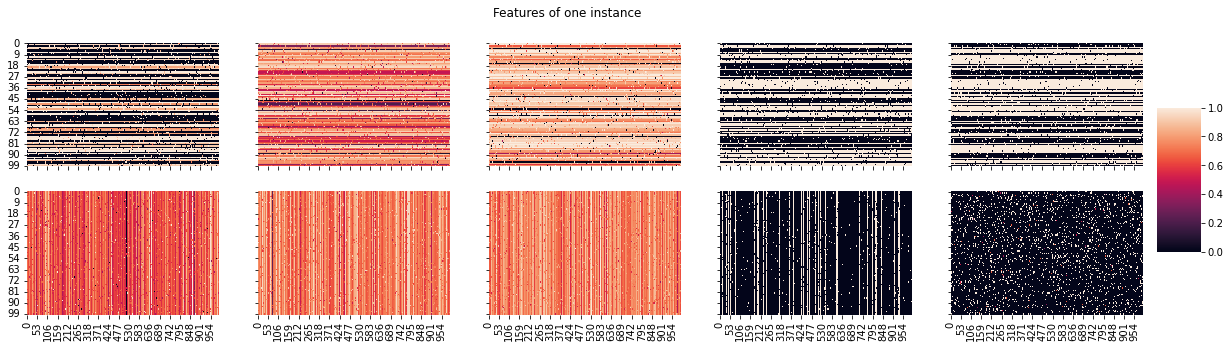

In [144]:
fig, axn = plt.subplots(2, 5, sharex=True, sharey=True, figsize = (20,5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    sns.heatmap(X_train[1,:,:,i], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)



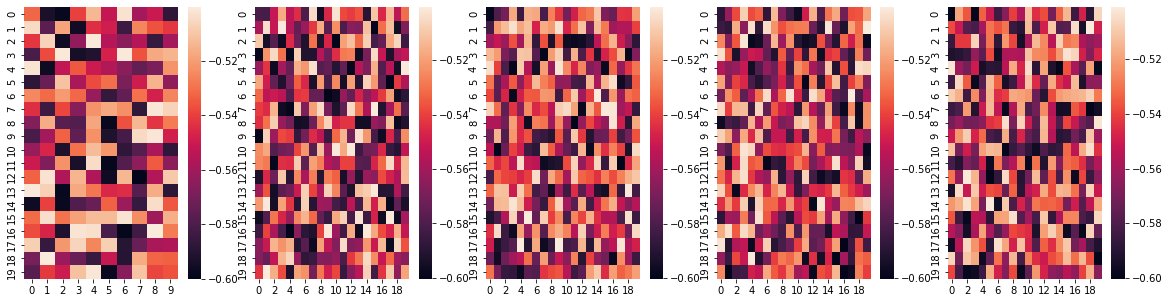

In [140]:
fig,ax = plt.subplots(min(num_layers // 5, 1) , 5, figsize = (20,5))

for i,ax in enumerate(ax.flat) :
    sns.heatmap(net[2*i].weight.detach().cpu().numpy(), ax=ax)
    

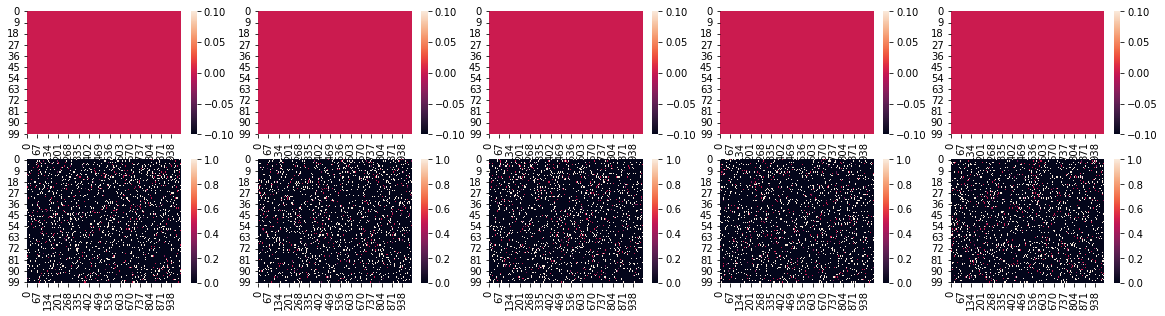

In [136]:
fig,ax = plt.subplots((num_layers // 5) , 5, figsize = (20,5))
netcpu = copy.deepcopy(net).to('cpu')

for i,ax in enumerate(ax.flat) :
    if i < 5 : 
        sns.heatmap(netcpu(X_train[i]).view_as(Y_train[0]).detach(), ax=ax)
    else : 
        sns.heatmap(Y_train[i-5], ax=ax)

end